<h3> Library validation with Anylogistix </h3>


We have created a single node supply chain model in Anylogistix, and implemented the same using SupplyNetPy.
We have increamentally added more nodes to the system to increase its complexity.

We have noted observations from this experiment in this notebook as we proceeded with the implementations.

In [1]:
# let us first import the libraries
# local import for convinience
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

In [4]:
import simpy
env = simpy.Environment()
supplier = scm.Supplier(env=env, ID='S1', name='Supplier 1', node_type='infinite_supplier')
distributor = scm.InventoryNode(env=env, ID='D1', name='Distributor 1', node_type='distributor', capacity=5000, initial_level=1000, 
                                inventory_holding_cost=0.2, replenishment_policy=scm.RQReplenishment, policy_param={'R':500,'Q':500}, 
                                product_sell_price=250, product_buy_price=200)

link1  = scm.Link(env=env, ID='L1', source=supplier, sink=distributor, cost=10, lead_time=lambda: 2)

demand1 = scm.Demand(env=env, ID='demand_1', name='Dem 1', order_arrival_model=lambda: 2, order_quantity_model=lambda:80, 
                     demand_node=distributor, delivery_cost=lambda: 10)
demand2 = scm.Demand(env=env, ID='demand_2', name='Dem 2', order_arrival_model=lambda: 2, order_quantity_model=lambda:120, 
                     demand_node=distributor, delivery_cost=lambda: 10)

scm.global_logger.enable_logging()
env.run(until=60)

INFO sim_trace - 0.0000:demand_1:Customer0:Demand at Distributor 1, Order quantity:80, available.
INFO sim_trace - 0.0000:demand_2:Customer0:Demand at Distributor 1, Order quantity:120, available.
INFO sim_trace - 0.0000:demand_1:Customer0:Demand at Distributor 1, Order quantity:80 received. Current inv: 800
INFO sim_trace - 0.0000:demand_2:Customer0:Demand at Distributor 1, Order quantity:120 received. Current inv: 800
INFO sim_trace - 0.9990:D1: Inventory levels:800
INFO sim_trace - 1.9990:D1: Inventory levels:800
INFO sim_trace - 2.0000:demand_1:Customer1:Demand at Distributor 1, Order quantity:80, available.
INFO sim_trace - 2.0000:demand_2:Customer1:Demand at Distributor 1, Order quantity:120, available.
INFO sim_trace - 2.0000:demand_1:Customer1:Demand at Distributor 1, Order quantity:80 received. Current inv: 600
INFO sim_trace - 2.0000:demand_2:Customer1:Demand at Distributor 1, Order quantity:120 received. Current inv: 600
INFO sim_trace - 2.9990:D1: Inventory levels:600
INFO 

available inv =  500
inventory cost =  7200.0
inv spend =  1100000
transport costs =  110.0 300 300


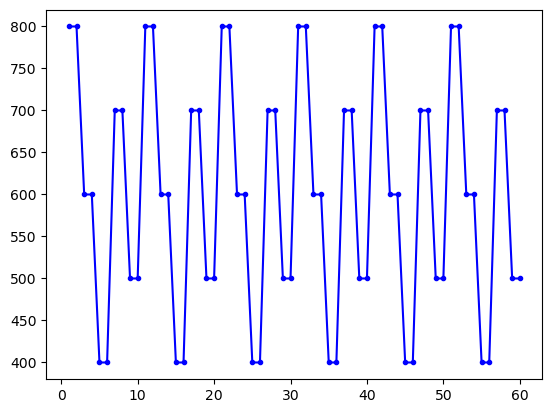

In [5]:
import numpy as np
import matplotlib.pyplot as plt

print("available inv = ",distributor.inventory.inventory.level)
print("inventory cost = ",distributor.inventory_cost)
print("inv spend = ",sum([x[1] for x in distributor.inventory.inventory_spend]))
inv_levels = np.array(distributor.inventory.instantaneous_levels)
transport_costs = np.array(distributor.transportation_cost)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
print("transport costs = ", sum(transport_costs[:,1]), sum([x[1] for x in demand1.transportation_cost]), sum([x[1] for x in demand2.transportation_cost]))


In [11]:
"""
Single Echelon Single node

Product: Nasal Spray
    Sell price: 30
    Cost: 24

Network consists of one supplier, one distributor and demand at the distributor
Supplier: Infinite supplier
    loc: Vasco
Distributor: 
    loc: Mumbai
    replenish policy: (s=500, S=1000), ini = 1000
    Dist to supplier: 570 km (11 hrs)
    delivery lead time: 1 day
Retailer (Customer):
    loc: Pune
    order interval: 5 days
    order quantity: 20
    Dist to Distributor: 152 km (3 hrs)

A Distributor is added:
    loc: Dharwad
    replenish policy: (s=400, S=800), ini = 800
    delivery lead time: 1 day

Customers are added:
    1. Pune: order interval: 7 days, order quantity: 50, lead time: 0.9 days
    2. Kalyan: order interval: 3 days, order quantity: 35, lead time: 0.9 days
    3. Thane: order interval: 2 days, order quantity: 30, lead time: 0.9 days
    4. Panvel: order interval: 5 days, order quantity: 65, lead time: 0.9 days
    5. Hubli: order interval: 7 days, order quantity: 60, lead time: 0.9 days
    6. Khanapur: order interval: 5 days, order quantity: 25, lead time: 0.9 days
    7. Belgavi: order interval: 3 days, order quantity: 30, lead time: 0.9 days
"""
import simpy
import numpy as np
import matplotlib.pyplot as plt

env = simpy.Environment()
supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier")

mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=150, 
                             manufacturing_time=1, sell_price=300, buy_price=150,
                             raw_materials=[], units_per_cycle=3000) # create a default product

distributor = scm.InventoryNode(env=env, ID='D1', name='Mumbai Warehouse', node_type="warehouse", 
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22, product=mouse,
                                replenishment_policy="sS", policy_param=[500], product_sell_price=300)

distributor2 = scm.InventoryNode(env=env, ID='D1', name='Dharwad Warehouse', node_type="warehouse", 
                                capacity=800, initial_level=800, inventory_holding_cost=0.22, product=mouse,
                                replenishment_policy="sS", policy_param=[400], product_sell_price=300)

link = scm.Link(env=env, ID='L1', source=supplier, sink=distributor, cost=10, lead_time=lambda: 1)
link2 = scm.Link(env=env, ID='L2', source=supplier, sink=distributor2, cost=10, lead_time=lambda: 1)

demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand Pune', order_arrival_model=lambda: 7, 
                        order_quantity_model=lambda:50, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand Kalyan', order_arrival_model=lambda: 3, 
                        order_quantity_model=lambda:35, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor)
demand3 = scm.Demand(env=env, ID='demand_D3', name='Demand Thane', order_arrival_model=lambda: 2, 
                        order_quantity_model=lambda:30, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor)
demand4 = scm.Demand(env=env, ID='demand_D4', name='Demand Panvel', order_arrival_model=lambda: 5, 
                        order_quantity_model=lambda:65, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor)
demand5 = scm.Demand(env=env, ID='demand_D5', name='Demand Hubli', order_arrival_model=lambda: 7, 
                        order_quantity_model=lambda:60, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor2)
demand6 = scm.Demand(env=env, ID='demand_D6', name='Demand Khanapur', order_arrival_model=lambda: 5, 
                        order_quantity_model=lambda:25, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor2)
demand7 = scm.Demand(env=env, ID='demand_D7', name='Demand Belgavi', order_arrival_model=lambda: 3, 
                        order_quantity_model=lambda:30, delivery_cost=lambda:10, lead_time=lambda:0.9, 
                        demand_node=distributor2)
env.run(until=365)

INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Mumbai Warehouse, Order quantity:50, available.
INFO sim_trace - 0.0000:demand_D2:Customer0:Demand at Mumbai Warehouse, Order quantity:35, available.
INFO sim_trace - 0.0000:demand_D3:Customer0:Demand at Mumbai Warehouse, Order quantity:30, available.
INFO sim_trace - 0.0000:demand_D4:Customer0:Demand at Mumbai Warehouse, Order quantity:65, available.
INFO sim_trace - 0.0000:demand_D5:Customer0:Demand at Dharwad Warehouse, Order quantity:60, available.
INFO sim_trace - 0.0000:demand_D6:Customer0:Demand at Dharwad Warehouse, Order quantity:25, available.
INFO sim_trace - 0.0000:demand_D7:Customer0:Demand at Dharwad Warehouse, Order quantity:30, available.
INFO sim_trace - 0.9000:demand_D1:Customer0:Demand at Mumbai Warehouse, Order quantity:50 received. Current inv: 820
INFO sim_trace - 0.9000:demand_D2:Customer0:Demand at Mumbai Warehouse, Order quantity:35 received. Current inv: 820
INFO sim_trace - 0.9000:demand_D3:Customer0:Deman

Performance:
	Available Inventory: [695, 365], Total = 1060
	Inventory cost: [58260.4, 47849.99999999997], Total = 106110.39999999997
	Inventory Spend: [2527500, 1234500], Total = 3762000
	Transportation cost: [320, 200, 530, 1220, 1830, 730, 530, 730, 1220], Total = 7310
	Total cost: [2586080.4, 1282550.0, 530, 1220, 1830, 730, 530, 730, 1220], Total = 3875420.4
	Total #products sold: [2650, 4270, 5490, 4745, 3180, 1825, 3660], Total = 25820
	Sell price: 300
	Total revenue: 7746000
	Net profit (Totalcost - Revenue): 3870579.6


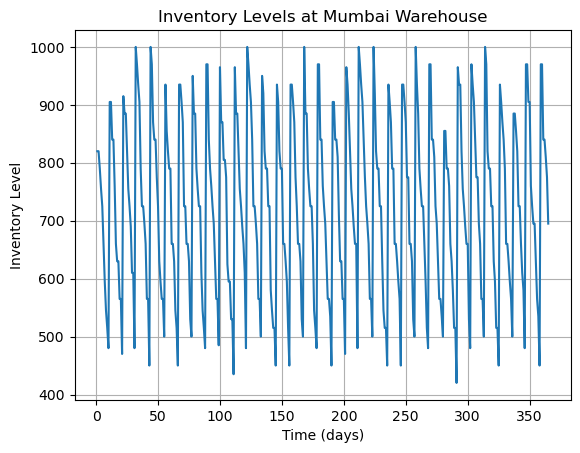

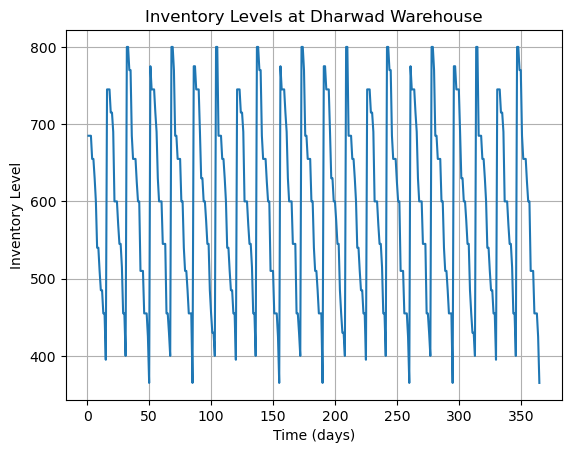

In [12]:

nodes = [distributor, distributor2]
demands = [demand1, demand2, demand3, demand4, demand5, demand6, demand7]

available_inventory = []
inventory_costs = []
inventory_spends = []
tranportation_costs = []
total_costs = []
total_units_sold = []

for node in nodes:
    available_inventory.append(node.inventory.inventory.level)
    inventory_costs.append(node.inventory_cost)
    inventory_spends.append(sum([x[1] for x in node.inventory.inventory_spend]))
    tranportation_costs.append(sum([x[1] for x in node.transportation_cost]))
    total_costs.append(node.node_cost)

for demand in demands:
    if(demand.transportation_cost):
        tranportation_costs.append(demand.node_cost)
        total_units_sold.append(demand.total_products_sold)
        total_costs.append(demand.node_cost)


print(f"Performance:")
print(f"\tAvailable Inventory: {available_inventory}, Total = {sum(available_inventory)}")
print(f"\tInventory cost: {inventory_costs}, Total = {sum(inventory_costs)}")
print(f"\tInventory Spend: {inventory_spends}, Total = {sum(inventory_spends)}")
print(f"\tTransportation cost: {tranportation_costs}, Total = {sum(tranportation_costs)}")

print(f"\tTotal cost: {total_costs}, Total = {sum(total_costs)}")
print(f"\tTotal #products sold: {total_units_sold}, Total = {sum(total_units_sold)}")
print(f"\tSell price: {mouse.sell_price}")
revenue = sum(total_units_sold) * mouse.sell_price
print(f"\tTotal revenue: {revenue}")
print(f"\tNet profit (Totalcost - Revenue): {revenue - sum(total_costs)}")

for node in nodes:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0],inv_levels[:,1], label=node.name)
    plt.title(f'Inventory Levels at {node.name}')
    plt.xlabel('Time (days)')
    plt.ylabel('Inventory Level')
    plt.grid() # add grid
    plt.show()